Entrenamos un predictor decission tree para hacer prediccion de mortalidad y lo evaluamos con AUROC

In [0]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


#Necesitamos mostrar graficamente las areas de decision
#Definimos una funcion para mostrarlas (tomada de Rashka - Python Machine Learning)

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.01):

    # establecemos marcadores y colores
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('blue', 'red', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # mostramos la superficie de decision
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # destacamos los casos de test
    if test_idx is not None:
      if test_idx.shape[0]>0:
        # dibujamos todos
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')






In [2]:
#Importamos los datos de un fichero csv
import pandas as pd
df = pd.read_csv('ejemploMI.csv')
df.tail()


,Unnamed: 0,X,exitus,apache2,tipopaciente,sexopac,edad,sofa,lactato
1360,1364,1364,0,24,QU,Hombre,68,5,1.9
1361,1365,1365,0,18,QP,Hombre,55,5,1.5
1362,1366,1366,0,13,QP,Hombre,68,2,4.9
1363,1367,1367,0,10,QU,Hombre,33,1,1.1
1364,1368,1368,0,8,QP,Hombre,64,4,4.8


In [3]:
import matplotlib.pyplot as plt
import numpy as np               # primero un ejemplo sencillo con solo dos variables (apache y lactato)
#Utilizamos solo pacientes con tipo de ingreso medico o quirurgico urgente
X = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[2,3,8]].values    # la variable X tiene los valores de apache2 (columna 3), lactato (columna 8) y exitus (columna 2,variable resultado)
                                   

print("Clases target iniciales: ",np.unique(X[:,0]))


Clases target iniciales:  [0. 1.]


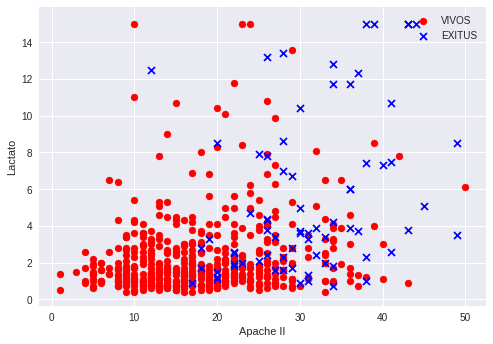

In [4]:
plt.scatter(X[X[:,0]==0,1],X[X[:,0]==0,2],color="red",marker="o",label="VIVOS")
plt.scatter(X[X[:,0]==1,1],X[X[:,0]==1,2],color="blue",marker="x",label="EXITUS")
plt.xlabel("Apache II")
plt.ylabel("Lactato")
plt.legend(loc="upper right")
plt.show()

In [5]:
#Vemos que hay un valor de lactato que se sale de la capacidad de medición del gasómetro (hasta 15). Lo eliminamos ya que es un único valor
df=df[df['lactato']<=15]
print('Lactato máximo',df['lactato'].max())
#Mostramos el apache2 minimo para exitus
print("Apache 2 minimo en exitus",df[df['exitus']==1]['apache2'].min())

Lactato máximo 15.0
Apache 2 minimo en exitus 12


Valores unicos de la clase target  [0 1]
Shapes: lasX:  579 ; laY:  579 ; indices:  579
      apache2  lactato
660        33      6.5
140        22      5.6
439        20      0.7
1268       17      4.2
33         12      1.7
Instancias de exitus: [  0 506  73]
Intancias en train: [  0 354  51]
Instancias en test: [  0 152  22]
Mal clasificados: 23
Bien clasificados: 151
Exitus predicho: 11
Vivo predicho: 163
Falsos exitus: 6
Falsos vivos: 17
Porcentaje de acierto: 0.87 ; si predecimos todos vivos sería del  0.8735632183908046


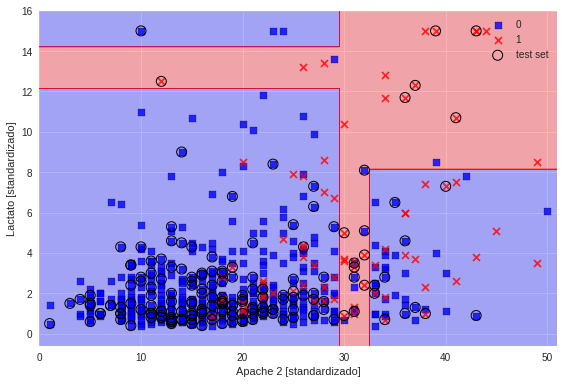

In [10]:
#Ahora entrenamos un arbol de decision y evaluamos su capacidad predictiva

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

lasX = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[3,8]]
laY = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,2]
#laY = np.where(laY==1,-1,1)  En este caso usamos 0 y 1 como valores de las clases porque este predictor lo hace así
print("Valores unicos de la clase target ",np.unique(laY)) 

#Dividimos el dataframe en un set de training y otro de test, homogeneamente representados en cuanto al target
indices = np.arange(lasX.shape[0])

print("Shapes: lasX: ",lasX.shape[0], "; laY: ",laY.shape[0],"; indices: " ,indices.shape[0])
lasX_train,lasX_test,laY_train,laY_test,indexes_train,indexes_test = \
    train_test_split(lasX,laY,indices,test_size=0.3,random_state=None,stratify=df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')]['exitus'].values)

print(lasX_test.tail())

print("Instancias de exitus:" , np.bincount(laY+1))
print("Intancias en train:" , np.bincount(laY_train+1))
print("Instancias en test:" , np.bincount(laY_test+1))

#Creamos el arbol de decision y lo entrenamos
tree1 = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=None)
tree1.fit(lasX_train,laY_train)

#Realizamos las predicciones y evaluamos
laY_pred = tree1.predict(lasX_test)
print('Mal clasificados: %d' % (laY_test!=laY_pred).sum())
print('Bien clasificados: %d' % (laY_test==laY_pred).sum())
print('Exitus predicho: %d' % (1==laY_pred).sum())
print('Vivo predicho: %d' % (0==laY_pred).sum())


print('Falsos exitus: %d' % ((laY_test==0)&(laY_pred==1)).sum())
print('Falsos vivos: %d' % ((laY_test==1)&(laY_pred==0)).sum())

print('Porcentaje de acierto: %.2f' % accuracy_score(laY_test,laY_pred), "; si predecimos todos vivos sería del ",1-laY_test.mean())

lasX_combined = np.vstack((lasX_train, lasX_test))
laY_combined = np.hstack((laY_train, laY_test))


plot_decision_regions(X=lasX_combined, y=laY_combined,
                      classifier=tree1, test_idx=indexes_test ) #indexes_test)  
plt.xlabel('Apache 2 [standardizado]')
plt.ylabel('Lactato [standardizado]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [14]:
# Ahora añadimos otras variables al predictor: sofa al ingreso y edad

lasX2 = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,[3,6,7,8]]  #sofa esta en la columna 7, edad en la 6
laY2 = df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')].iloc[:,2]
#laY2 = np.where(laY==1,-1,1)   Usamos como clases 0 y 1

lasX2_train,lasX2_test,laY2_train,laY2_test = \
      train_test_split(lasX2,laY2,test_size=0.3,random_state=None,stratify=df[(df['tipopaciente']=='QU') | (df['tipopaciente']=='M')]['exitus'].values)

tree2 = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=None)
tree2.fit(lasX2_train,laY2_train)


laY2_pred = tree2.predict(lasX2_test)
print('Mal clasificados: %d' % (laY2_test!=laY2_pred).sum())
print('Bien clasificados: %d' % (laY2_test==laY2_pred).sum())
print('Vivo predicho: %d' % (0==laY2_pred).sum())
print('Exitus predicho: %d' % (1==laY2_pred).sum())


print('Falsos vivos: %d' % ((laY2_test==1)&(laY2_pred==0)).sum())
print('Falsos exitus: %d' % ((laY2_test==0)&(laY2_pred==1)).sum())

print('Porcentaje de acierto: %.2f' % accuracy_score(laY2_test,laY2_pred), "; si predecimos todos vivos sería del ",1-laY_test.mean())



Mal clasificados: 23
Bien clasificados: 151
Vivo predicho: 171
Exitus predicho: 3
Falsos vivos: 21
Falsos exitus: 2
Porcentaje de acierto: 0.87 ; si predecimos todos vivos sería del  0.8735632183908046


In [35]:
#Ahora usamos un ensamble para ver si mejora la capacidad de decision

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=None)
forest.fit(lasX2_train, laY2_train)

laY2_pred = forest.predict(lasX2_test)
print('Mal clasificados: %d' % (laY2_test!=laY2_pred).sum())
print('Bien clasificados: %d' % (laY2_test==laY2_pred).sum())
print('Vivo predicho: %d' % (0==laY2_pred).sum())
print('Exitus predicho: %d' % (1==laY2_pred).sum())


print('Falsos vivos: %d' % ((laY2_test==1)&(laY2_pred==0)).sum())
print('Falsos exitus: %d' % ((laY2_test==0)&(laY2_pred==1)).sum())

print('Porcentaje de acierto: %.2f' % accuracy_score(laY2_test,laY2_pred), "; si predecimos todos vivos sería del ",1-laY_test.mean())




Mal clasificados: 22
Bien clasificados: 152
Vivo predicho: 160
Exitus predicho: 14
Falsos vivos: 15
Falsos exitus: 7
Porcentaje de acierto: 0.87 ; si predecimos todos vivos sería del  0.8735632183908046
